In [96]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


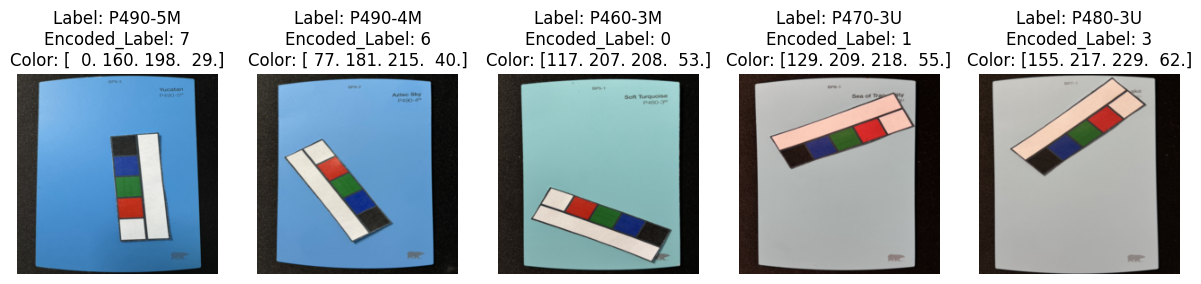

In [97]:
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder

# Data loading
class ColorDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.image_labels = pd.read_csv(csv_file, encoding='utf-8')
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_labels)
    
    def __getitem__(self, idx):
        img_name = self.image_labels.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, img_name+'.jpg')
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)


        class_label = self.image_labels.iloc[idx]['label']

        label_encoder = LabelEncoder()
        self.image_labels['encoded_label'] = label_encoder.fit_transform(self.image_labels['label'])

        class_encoded_label = self.image_labels.iloc[idx]['encoded_label']
        class_encoded_label = torch.tensor(class_encoded_label, dtype=torch.long)

        color_code = self.image_labels.iloc[idx][['r', 'g', 'b', 'LRV']].values.astype('float32')
        color_code = torch.tensor(color_code, dtype=torch.float32)

        return image, class_label, color_code, class_encoded_label
    
original_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

csv_file = r'D:\COSI149\color_with_label\label.csv'
if not os.path.isfile(csv_file):
    raise FileNotFoundError(f"The file {csv_file} does not exist. Please provide the correct path to the file.")

img_dir = r'D:\COSI149\color_with_label'  # Update this path to the correct directory containing images
original_dataset = ColorDataset(csv_file=csv_file, img_dir=img_dir, transform=original_transform)



# Visualize the data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    image, class_label, color_code, class_encoded_label = original_dataset[i*7]
    ax[i].imshow(transforms.ToPILImage()(image))
    ax[i].set_title(f'Label: {class_label}\nEncoded_Label: {class_encoded_label}\nColor: {color_code.numpy()}')
    ax[i].axis('off')

plt.show()



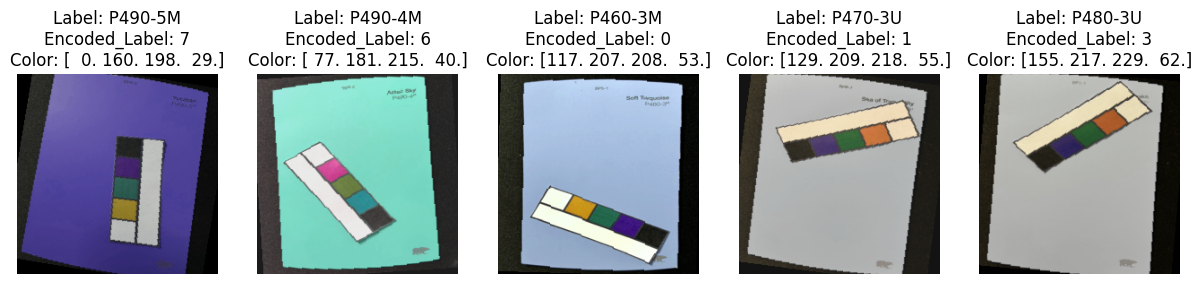

In [98]:
# use torchvision to do data augmentation
import torchvision.transforms as transforms

# Define a transform to augment the data
augmented_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

# create the dataset with the new transform
augmented_dataset = ColorDataset(csv_file=csv_file, img_dir=img_dir, transform=augmented_transform)


# Visualize the augmented data
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    image, class_label, color_code, class_encoded_label = augmented_dataset[i*7]
    ax[i].imshow(transforms.ToPILImage()(image))
    ax[i].set_title(f'Label: {class_label}\nEncoded_Label: {class_encoded_label}\nColor: {color_code.numpy()}')
    ax[i].axis('off')

plt.show()  

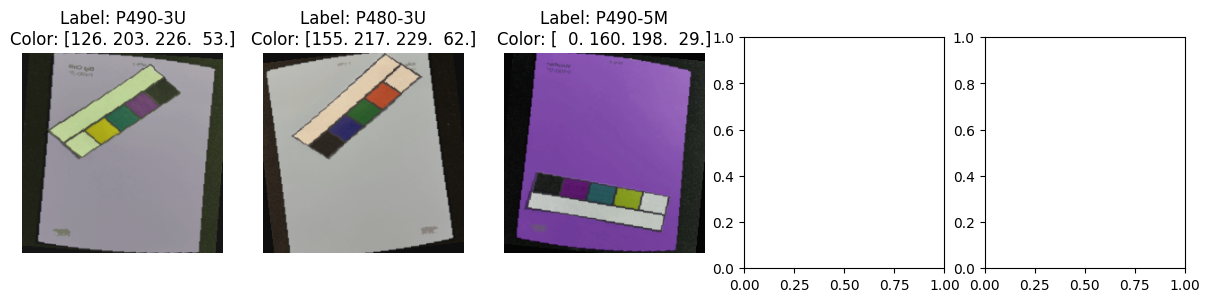

3

In [99]:
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

conbined_dataset = ConcatDataset([original_dataset, augmented_dataset])

data_loader = DataLoader(conbined_dataset, batch_size=32, shuffle=True)

# Visualize the data   
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i, (images, class_labels, color_codes, class_encoded_label) in enumerate(data_loader):
    if i >= 3:
        break
    ax[i].imshow(transforms.ToPILImage()(images[0]))
    ax[i].set_title(f'Label: {class_labels[0]}\nColor: {color_codes[0].numpy()}')
    ax[i].axis('off')

plt.show()

data_loader.__len__()

In [100]:
# Model Architecture
import torch.nn as nn
from torchvision import models

class MultiTaskColorModel(nn.Module):
    def __init__(self, num_classes, regression_output_size):
        super(MultiTaskColorModel, self).__init__()

        #Use a pre-trained ResNet model as the backbone
        self.backbone = models.resnet152(pretrained=True)
        num_features = self.backbone.fc.in_features

        #Remove the final classification layer
        self.backbone.fc = nn.Identity()

        #Add a new classification head
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

        #Add a new regression head
        self.regressor = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, regression_output_size)
        )


    def forward(self, x):
        features = self.backbone(x)
        class_out = self.classifier(features)
        reg_out = self.regressor(features)


        return class_out, reg_out
    

# Loss function and Opatimizer
import torch.optim as optim

criterion_class = nn.CrossEntropyLoss()
criterion_reg = nn.MSELoss()

# Hyperparameters for balancing the regerssion loss
regression_loss_weight = 1.0

#Optimizer
learning_rate = 0.001
model = MultiTaskColorModel(num_classes=8, regression_output_size=4)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

C:\Users\zjr02\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zjr02\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [101]:
# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels, color_codes, encoded_labels in data_loader:
        images = images.to(device)
        labels = encoded_labels.to(device)
        color_codes = color_codes.to(device)

        optimizer.zero_grad()

        class_outputs, reg_outputs = model(images)

        loss_class = criterion_class(class_outputs, labels)
        loss_reg = criterion_reg(reg_outputs, color_codes)

        # Total loss is a weighted sum of classification and regression losses
        loss = loss_class + regression_loss_weight * loss_reg

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/30], Loss: 24001.7539
Epoch [2/30], Loss: 20072.7194
Epoch [3/30], Loss: 14384.9762
Epoch [4/30], Loss: 8603.5879
Epoch [5/30], Loss: 3939.7912
Epoch [6/30], Loss: 1187.0743
Epoch [7/30], Loss: 971.3712
Epoch [8/30], Loss: 641.6941
Epoch [9/30], Loss: 562.3652
Epoch [10/30], Loss: 577.0692
Epoch [11/30], Loss: 514.6851
Epoch [12/30], Loss: 440.3852
Epoch [13/30], Loss: 401.8608
Epoch [14/30], Loss: 381.2495
Epoch [15/30], Loss: 414.8845
Epoch [16/30], Loss: 375.8776
Epoch [17/30], Loss: 347.5753
Epoch [18/30], Loss: 340.0524
Epoch [19/30], Loss: 304.1035
Epoch [20/30], Loss: 317.8402
Epoch [21/30], Loss: 286.1278
Epoch [22/30], Loss: 289.5843
Epoch [23/30], Loss: 240.0521
Epoch [24/30], Loss: 222.0847
Epoch [25/30], Loss: 200.2239
Epoch [26/30], Loss: 199.7434
Epoch [27/30], Loss: 196.0594
Epoch [28/30], Loss: 159.4538
Epoch [29/30], Loss: 159.4571
Epoch [30/30], Loss: 132.1378


In [102]:
# save the model
torch.save(model, 'color_model.pth')
